# 1. Prelimitary

In [1]:
import numpy as np
import random
from project_utils import load_train_set, load_test_set, hint

random.seed()
np.random.seed()

TRAIN_PATH = 'data/train/'
TEST_PATH = 'data/test/'

hint("Loading train set...")
train = load_train_set(TRAIN_PATH)

hint("Loading test set...")
test = load_test_set(TEST_PATH)

hint("Done!")

Done!


# 2. Preprocessing

In [2]:
from project_utils import standardize_images

IMAGE_DIM = (256, 256)

hint("Working on X...")
X = standardize_images(train['image'], shape=IMAGE_DIM)
hint("Working on Y...")
Y = standardize_images(train['mask'], shape=IMAGE_DIM, dtype=np.bool)
hint("Working on X_...")
X_ = standardize_images(test['image'], shape=IMAGE_DIM)

hint("Done!")

Done!


In [3]:
from project_utils import augment_data

X, Y = augment_data(X, Y, rotate=True, inverse_color=True)
print("%d samples added (total %d)" % (X.shape[0]-train.shape[0], X.shape[0]))

1340 samples added (total 2010)


# 3. Model

In [4]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, concatenate
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D
from keras.optimizers import Adam

CONV_BASE_SIZE = 16
CONV_KERNEL = (3, 3)
TRAN_KERNEL = (3, 3)
CONV_ACTIVATION = 'relu'
CONV_PADDING = 'same'
CONV_KERNEL_INIT = 'glorot_normal'
CONV_DROPOUT = 0.1
POOLING_SIZE = (2, 2)
OPTIMIZER = Adam(lr=0.0005)

def build_conv_layer(filter_size):
    """
    build a convolution layer using the preset hyperparameters
    """
    return Conv2D(
        filter_size, 
        kernel_size=CONV_KERNEL,
        padding=CONV_PADDING,
        activation=CONV_ACTIVATION,
        kernel_initializer=CONV_KERNEL_INIT
    )

def build_conv_block(connect, depth):
    """
    build a 2-convolutional-layer block
    """
    filter_size = CONV_BASE_SIZE*(2**depth)
    x = build_conv_layer(filter_size)(connect)
    x = Dropout(CONV_DROPOUT)(x)
    x = build_conv_layer(filter_size)(x)
    return x

def build_upsample_block(connect, merge, depth):
    """
    build a upsampling block
    """
    filter_size = CONV_BASE_SIZE*(2**depth)
    x = Conv2DTranspose(
        filter_size, 
        TRAN_KERNEL, 
        strides=POOLING_SIZE, 
        padding=CONV_PADDING
    )(connect)
    return concatenate([x, merge])

c:\users\chuanli\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
# input layer
inputs = Input((IMAGE_DIM + (1,)))

# downsampling layers (left of the U)
down_conv_0 = build_conv_block(inputs, depth=0)
down_pool_0 = MaxPooling2D(POOLING_SIZE)(down_conv_0)
down_conv_1 = build_conv_block(down_pool_0, depth=1)
down_pool_1 = MaxPooling2D(POOLING_SIZE)(down_conv_1)
down_conv_2 = build_conv_block(down_pool_1, depth=2)
down_pool_2 = MaxPooling2D(POOLING_SIZE)(down_conv_2)
down_conv_3 = build_conv_block(down_pool_2, depth=3)
down_pool_3 = MaxPooling2D(POOLING_SIZE)(down_conv_3)

# bottom layer
conv_bottom = build_conv_block(down_pool_3, depth=4)

# upsampling layers (right of the U)
upsample_3 = build_upsample_block(conv_bottom, down_conv_3, 3)
up_conv_3 = build_conv_block(upsample_3, depth=3)
upsample_2= build_upsample_block(up_conv_3, down_conv_2, 2)
up_conv_2= build_conv_block(upsample_2, depth=2)
upsample_1= build_upsample_block(up_conv_2, down_conv_1, 1)
up_conv_1= build_conv_block(upsample_1, depth=1)
upsample_0= build_upsample_block(up_conv_1, down_conv_0, 0)
up_conv_0= build_conv_block(upsample_0, depth=0)

# output layer
outputs = Conv2D(1, (1, 1), activation='sigmoid')(up_conv_0)

# compile
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(
    optimizer=OPTIMIZER, 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 2320        dropout_1[0][0]                  
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 256, 256, 16) 0           conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 256, 256, 16) 2320        dropout_9[0][0]                  
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 1)  17          conv2d_18[0][0]                  
Total params: 2,158,417
Trainable params: 2,158,417
Non-trainable params: 0
__________________________________________________________________________________________________


In [6]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from sklearn.model_selection import train_test_split

BATCH_SIZE = 16
EPOCHS = 50
VALIDATION_SIZE = 0.1
BEST_MODEL_FILENAME = 'checkpoints/dsb2018-unet-benchmark-checkpoint.h5'
CALLBACKS = [
    ModelCheckpoint(BEST_MODEL_FILENAME, save_best_only=True)
]

Xtr, Xva, Ytr, Yva = train_test_split(X, Y, test_size=VALIDATION_SIZE)

history = model.fit(
    Xtr, Ytr, 
    validation_data=(Xva, Yva),
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    callbacks=CALLBACKS,
    verbose=2
)

model = load_model(BEST_MODEL_FILENAME)

Train on 1809 samples, validate on 201 samples
Epoch 1/50
 - 20s - loss: 0.4490 - acc: 0.8479 - val_loss: 0.3367 - val_acc: 0.8545
Epoch 2/50
 - 17s - loss: 0.2951 - acc: 0.8715 - val_loss: 0.3351 - val_acc: 0.8836
Epoch 3/50
 - 17s - loss: 0.2502 - acc: 0.9019 - val_loss: 0.2101 - val_acc: 0.9142
Epoch 4/50
 - 17s - loss: 0.2057 - acc: 0.9122 - val_loss: 0.1913 - val_acc: 0.9189
Epoch 5/50
 - 17s - loss: 0.1897 - acc: 0.9190 - val_loss: 0.1497 - val_acc: 0.9325
Epoch 6/50
 - 16s - loss: 0.1542 - acc: 0.9309 - val_loss: 0.1814 - val_acc: 0.9215
Epoch 7/50
 - 17s - loss: 0.1348 - acc: 0.9393 - val_loss: 0.1456 - val_acc: 0.9374
Epoch 8/50
 - 17s - loss: 0.1271 - acc: 0.9447 - val_loss: 0.1722 - val_acc: 0.9299
Epoch 9/50
 - 17s - loss: 0.1178 - acc: 0.9488 - val_loss: 0.1409 - val_acc: 0.9421
Epoch 10/50
 - 17s - loss: 0.1125 - acc: 0.9518 - val_loss: 0.1492 - val_acc: 0.9411
Epoch 11/50
 - 17s - loss: 0.1123 - acc: 0.9525 - val_loss: 0.1570 - val_acc: 0.9297
Epoch 12/50
 - 17s - loss: 

# 4. Conclusion

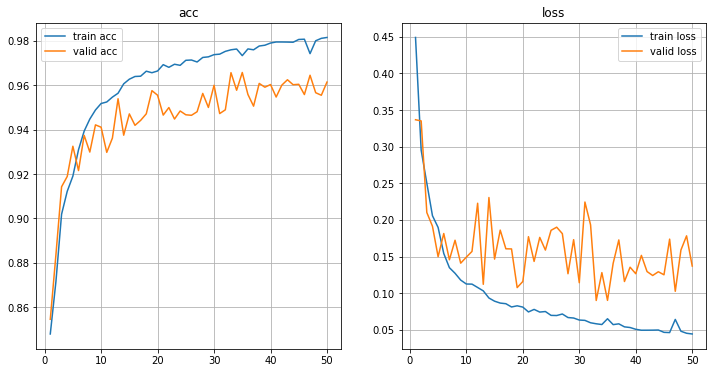

In [7]:
from project_utils import show_history

show_history(history.history)

In [9]:
from project_utils import format_prediction, make_submittable

PREDICTION_THRESHOLD = 0.5

Y_ = format_prediction(
    model.predict(X_), 
    original = test['image'],
    reduce_dimension=True
)

file_name = make_submittable(test['id'], Y_, title='benchmark')
print("Submittable file saved as \"%s\"" % file_name)

c:\users\chuanli\appdata\local\programs\python\python35\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Submittable file saved as "submission/benchmark_20180324-131045.csv"
